<a href="https://colab.research.google.com/github/PiotMik/OIS_curve_modeling/blob/main/OIS_Curve_modelling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Modelowanie krzywej OIS - przykład rynku GBP

# Wstęp

W tym notebooku prezentujemy model PCA-Factor Copula dla krzywej OIS rynku dłużnego funta.
Pokazujemy, że stopa OIS zależy od indexu SONIA, który natomiast jest zależny od stopy referencyjnej centralnego banku Wielkiej Brytanii.

Prezentujemy uproszczony model Hulla-White'a do symulacji indexu SONIA, co pozwala na ujęcie prognoz eksperckich co do zmian stopy referencyjnej. Pokazujemy również zastosowanie modelu PCA-Factor copula do modelowania ruchów krzywej OIS.

Cały model pozwala na symulację Monte Carlo ruchow krzywej OIS.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA 
import os
from typing import Callable, Optional
from datetime import date
from arch import arch_model
from sklearn.datasets import make_blobs
from statsmodels.distributions.empirical_distribution import ECDF


import plotly.graph_objects as go
from plotly.subplots import make_subplots
import pyvinecopulib as pv

plt.style.use('seaborn-whitegrid')
sns.set_context('talk')
sns.set_palette(sns.color_palette('tab10'))
plt.rcParams['figure.figsize'] = (10, 8)

# Dane

Dane dzienne dotyczące [OIS](https://www.bankofengland.co.uk/statistics/yield-curves) i [SONIA](https://www.bankofengland.co.uk/boeapps/database/fromshowcolumns.asp?Travel=NIxSUx&FromSeries=1&ToSeries=50&DAT=RNG&FD=1&FM=Jan&FY=2012&TD=13&TM=Mar&TY=2022&FNY=&CSVF=TT&html.x=189&html.y=40&C=5JK&Filter=N) są publicznie dostępne na stronie Bank of England. 

Do dyspozycji mamy 6 lat dziennych obserwacji SONII oraz 60 tenorów krzywej OIS.


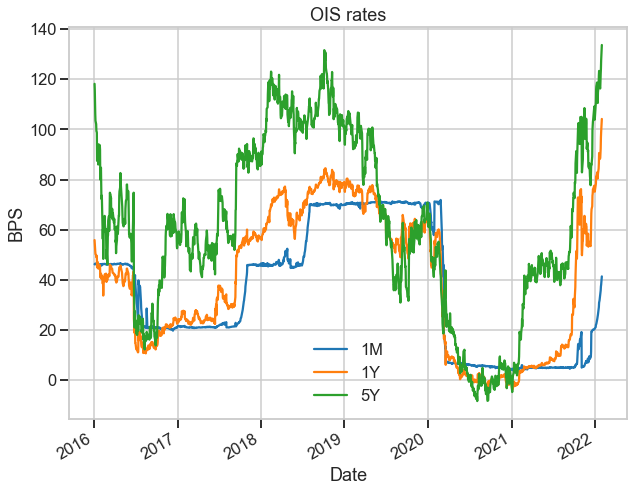

In [2]:
ois_url = 'https://raw.githubusercontent.com/PiotMik/OIS_curve_modeling/main/OIS%20spot.csv'
sonia_url = 'https://raw.githubusercontent.com/PiotMik/OIS_curve_modeling/main/SONIA.csv'

def tenor_parser(month_number: int):
  """
  Refactor integer month number into string like: 23 -> '1Y3Q2M' 

  Parameters
  ----------
  month_number: int
    Integer representing the number of months
  
  Returns
  -------
  str
    Formatted string
  """
  years = np.floor(month_number/12)
  months = (month_number - 12*years)

  y_str = f"{int(years)}Y" * int(years > 0)
  m_str = f"{int(months)}M" * int(months > 0)
  
  return y_str + m_str

# OIS load
ois = pd.read_csv(ois_url,
                  index_col= ['Maturity'], parse_dates=True, dayfirst=True)
ois = ois.sort_index()*100.0
ois.columns = [tenor_parser(int(month)) for month in ois.columns]
ois.index.name = 'Date'

# SONIA load
sonia = pd.read_csv(sonia_url,
                    index_col=['Date'], parse_dates=True, dayfirst=True)
sonia = sonia.sort_index()* 100.0

# Concatenate
rates = pd.concat([sonia, ois], axis = 1).dropna()

rates.iloc[:, [1, 12, 60]].plot()
plt.title('OIS rates')
plt.ylabel('BPS')
plt.xlabel('Date');

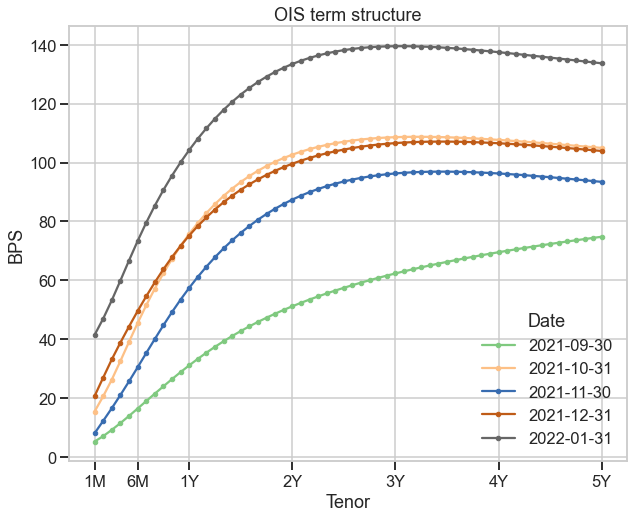

In [3]:
term_structure_df = rates.drop(['SONIA'], axis=1).tail(100).resample('M').last().T
term_structure_df.columns = term_structure_df.columns.strftime('%Y-%m-%d')

term_structure_df.plot(marker='.', cmap='Accent')
plt.ylabel('BPS')
plt.xlabel('Tenor')
_ = plt.title('OIS term structure')
tenors = np.array([1, 6, 12, 24, 36, 48, 60]) - 1
plt.xticks(tenors, ois.columns[tenors]);

# Model indexu SONIA

Sterling Overnight Index Average (SONIA) to alternatywna stopa referencyjna dla rynku dłużnego funta, która ma zastąpić GBP LIBOR po całkowitym jego wygaśnięciu.

SONIA obliczana jest jako średnia ucinana zaokrąglana do 4 miejsc po przecinku, brana na podstawie stóp procentowych obowiązujących na spełniających opowiednie warunki transakcjach depozytowych denominowanych w funcie sterlingu. 
Średnia ucinana używana do obliczania SONII jest ważona wolumenem, i bazowana na środkowych 50% rozkładu stóp procentowych. Transakcje brane pod uwage muszą być:

- Niesekurytyzowane i o jednodniowym terminie wygaśnięcia
- Wykonane między 00:00 and 18:00 czasu UK, o zapadalności transakcji tego samego dnia
- O wartości większej lub równej 25 mln funtów

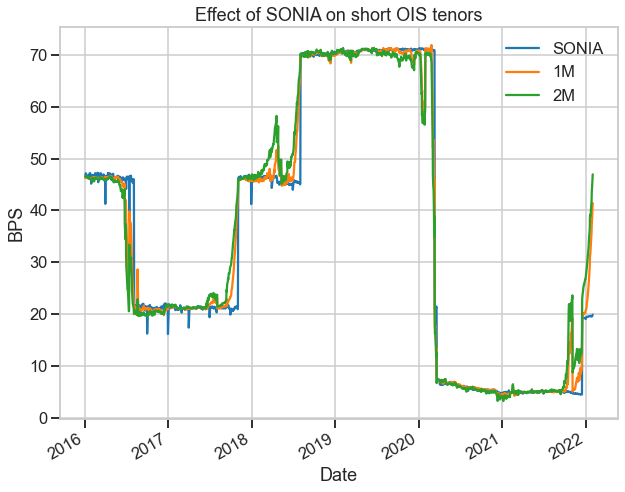

In [4]:
rates.iloc[:, :3].plot()
plt.title('Effect of SONIA on short OIS tenors')
plt.ylabel('BPS')
plt.xlabel('Date');

## Model Hulla-White'a

$$ dr_t = b(\mu_t - r_t)dt + \sigma dW_t$$ 


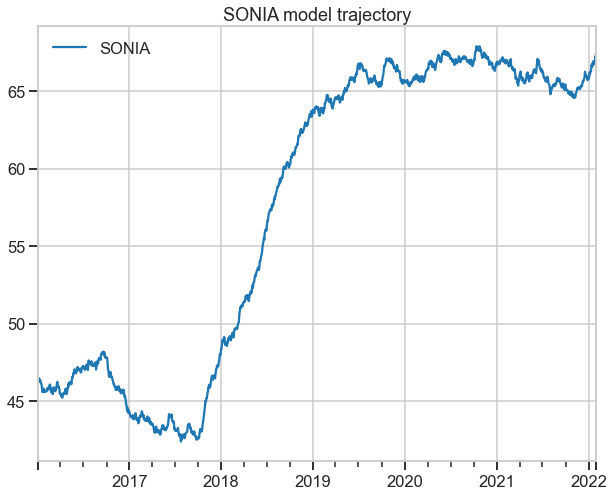

In [603]:
class HullWhiteModel():
    
    def __init__(self, b, mu_t, sigma):
        self.b = b
        self.mu_t = mu_t
        self.sigma = sigma

    def simulate(self,
                 x0, dates):
    
        dt = 1/255.
        xt = [x0.values[0]]
        t = [x0.index[0]]
        for i, date in enumerate(dates):
            x_k = xt[-1] + self.b*(self.mu_t(t[-1]) - xt[-1])*dt + self.sigma*np.random.randn()*np.sqrt(dt) # standard_t(df=2)
            xt.append(x_k)
            t.append(date)
        simulated_vals = pd.DataFrame(xt[1:], index = t[1:], columns = ['SONIA'])
        simulated_vals = pd.concat([x0, simulated_vals], axis=0)
        return simulated_vals

dates = ois.index[1:]

def mu_t(date):
    if date < np.datetime64('2016-09-01'):
        return sonia.iloc[0]
    elif date < np.datetime64('2017-10-01'):
        return sonia.iloc[0] - 5.
    elif date < np.datetime64('2018-06-01'):
        return sonia.iloc[0] + 10.
    else:
        return sonia.iloc[0] + 20.

model = HullWhiteModel(b = 2.0, # 70.0
                       mu_t = mu_t,
                       sigma = 2.0) # 2.0

xt = model.simulate(dates = dates,
                    x0 = sonia.iloc[[0], :])

xt.plot()
plt.title('SONIA model trajectory');

## Jak polityka BoE wpływa na krzywą OIS?

- [BoE rate](https://www.bankofengland.co.uk/monetary-policy/the-interest-rate-bank-rate)
- [SONIA rate](https://www.bankofengland.co.uk/boeapps/database/fromshowcolumns.asp?Travel=NIxSUx&FromSeries=1&ToSeries=50&DAT=RNG&FD=1&FM=Jan&FY=2012&TD=13&TM=Mar&TY=2022&FNY=&CSVF=TT&html.x=189&html.y=40&C=5JK&Filter=N)

## Model indexu SONIA, na podstawie BoE rate

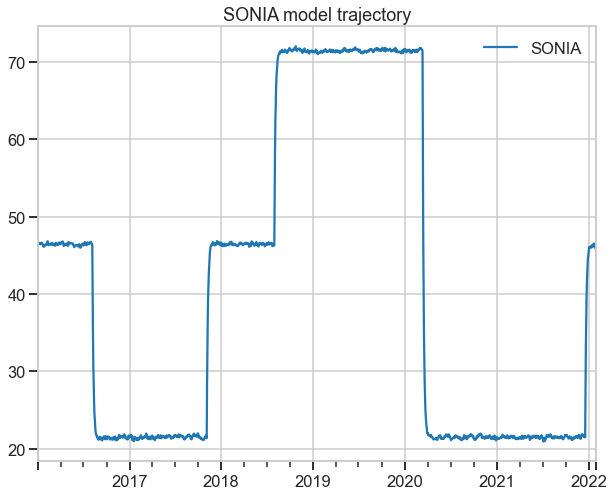

In [605]:
def boe_rate_pred(date):
    if date < np.datetime64('2016-08-05'):
        return sonia.iloc[0]
    elif date < np.datetime64('2017-11-03'):
        return sonia.iloc[0] - 25.
    elif date < np.datetime64('2018-07-31'):
        return sonia.iloc[0] + 0.
    elif date < np.datetime64('2020-03-11'):
        return sonia.iloc[0] + 25.
    elif date < np.datetime64('2020-03-20'):
        return sonia.iloc[0] - 25.
    elif date < np.datetime64('2020-03-20'):
        return sonia.iloc[0] - 40.
    elif date < np.datetime64('2021-12-17'):
        return sonia.iloc[0] - 25.
    else:
        return sonia.iloc[0] + 0.

sonia_model = HullWhiteModel(b = 70.0,
                             mu_t = boe_rate_pred,
                             sigma = 2.0)

sonia_sim = sonia_model.simulate(dates = dates,
                                 x0 = sonia.iloc[[0], :])

sonia_sim.plot()
plt.title('SONIA model trajectory');

# Model dynamiki krzywej OIS



<AxesSubplot:>

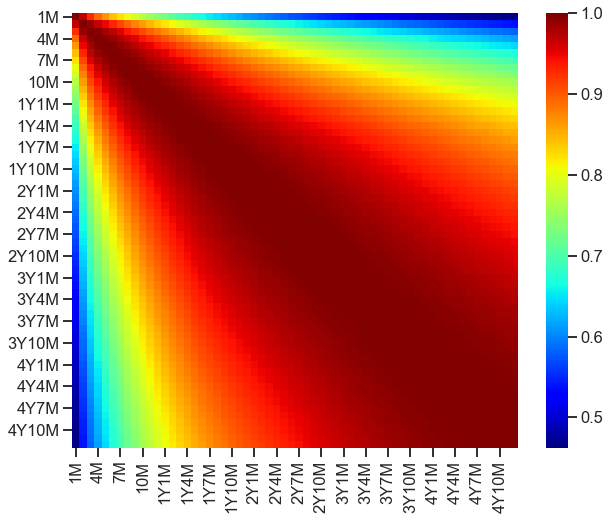

In [468]:
diffs = (rates[ois.columns].sub(rates['SONIA'], axis=0)).diff().dropna()

sns.heatmap(diffs.corr(), cmap='jet')

## PCA

### Idea


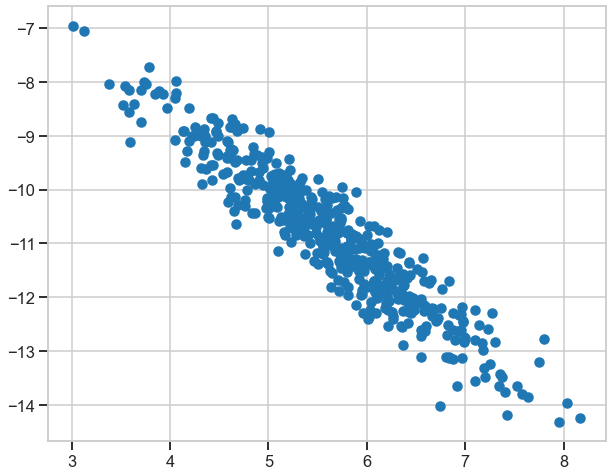

In [8]:
X, _ = make_blobs(n_samples=[500],  random_state=42)
transformation = [[-0.8, 0.9], [0.4, -0.95]]
X = np.dot(X, transformation)
plt.scatter(X[:, 0], X[:, 1]);

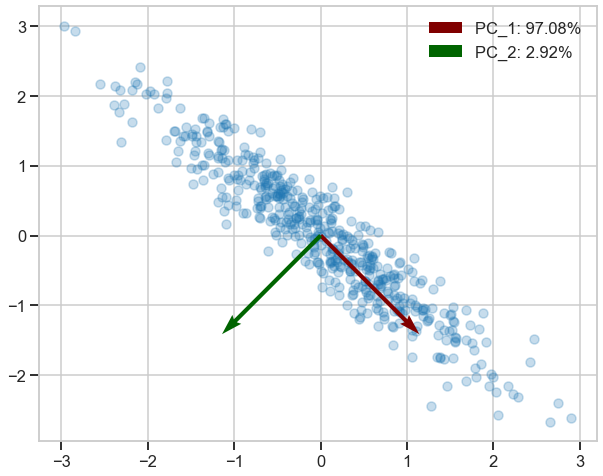

In [9]:
pca = PCA(2)

X = (X - X.mean(axis=0))/X.std(axis=0)
origin =  X.mean(axis=0)
pca.fit(X)
V = pca.components_

plt.scatter(X[:, 0], X[:, 1], alpha = 0.25)
plt.quiver(*origin, V[0, 1], V[0, 0],
           scale = 4,
           color='maroon', label=f'PC_1: {pca.explained_variance_ratio_[0]:.2%}')
plt.quiver(*origin, V[1, 1], V[1, 0],
           scale = 4,
           facecolor='darkgreen', label=f'PC_2: {pca.explained_variance_ratio_[1]:.2%}')
plt.legend()
plt.show()

### Zastosowanie do krzywej OIS

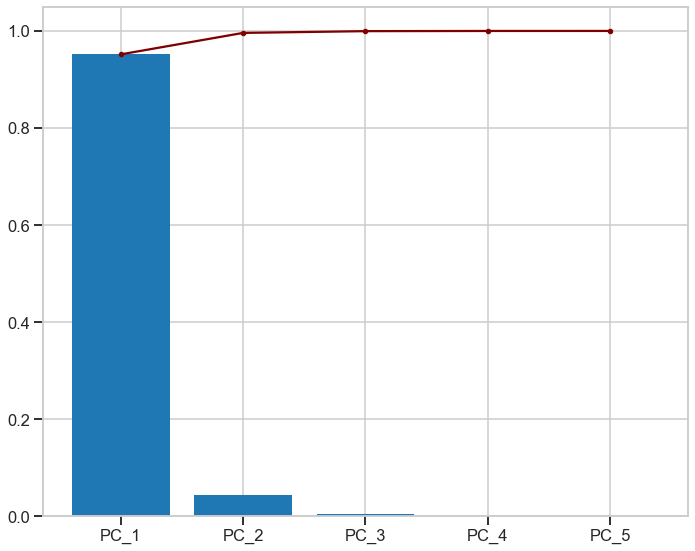

In [363]:
from sklearn.preprocessing import StandardScaler
long_tenors = ois.columns[12:]

sc = StandardScaler()
diffs = (rates[long_tenors].sub(rates['SONIA'], axis=0)).diff().dropna()
diffs = rates[long_tenors].diff().dropna()
sc.fit(diffs)

diffs_sc = sc.transform(diffs)
pca = PCA()
pca.fit(diffs_sc)

exp_var = pd.DataFrame(pca.explained_variance_ratio_,
                       index = [f"PC_{pair[0] + 1}" for pair in enumerate(pca.explained_variance_ratio_)],
                       columns = ['Explained variance'])
exp_var['Cumulative explained variance'] = pca.explained_variance_ratio_.cumsum()

max_n = 5
plt.bar(x = exp_var.index[:max_n], height = exp_var['Explained variance'][:max_n])
plt.plot(exp_var['Cumulative explained variance'][:max_n], marker='.', color='maroon')
plt.tight_layout()

In [365]:
exp_var.head(10)

,Explained variance,Cumulative explained variance
PC_1,9.517132e-01,0.951713
PC_2,4.424694e-02,0.995960
PC_3,3.598730e-03,0.999559
PC_4,3.796460e-04,0.999939
PC_5,5.457513e-05,0.999993
PC_6,6.482234e-06,1.000000
PC_7,3.892807e-07,1.000000
PC_8,2.015790e-08,1.000000
PC_9,9.100334e-10,1.000000
PC_10,5.264021e-11,1.000000


In [576]:
class PCA_term_structure():
    
    def __init__(self, pca_num):
        self.pca_num=pca_num

    def fit(self, data):
        tenor_data = data.drop(['SONIA'], axis=1)
        sonia_spreads = tenor_data.sub(data['SONIA'], axis=0)
        
        self.data = {'raw': data,
                     'sonia_spreads': sonia_spreads,
                     'diffs': sonia_spreads.diff().dropna(),
                     'T0': data.iloc[[0], :]}
        
        self.scaler = StandardScaler()
        self.scaler.fit(self.data['diffs'])
        self.data['diffs_scaled'] = self.scaler.transform(self.data['diffs'])
        
        self.pca = PCA(self.pca_num)
        self.pca.fit(self.data['diffs_scaled'])
        self.data['diffs_pca'] = self.pca.transform(self.data['diffs_scaled'])
        
        self.components = pd.DataFrame(self.pca.components_, 
                                       columns = tenor_data.columns,
                                       index=[f'PC_{i + 1}' for i in range(self.pca.n_components)]).T
        
    def plot_loadings(self):
        self.components.plot(marker='.')
        tenors = np.array([12, 24, 36, 48, 60]) - 12
        plt.xticks(tenors, ois.columns[tenors + 11])
        
    def plot_explained_variance(self):
        exp_var = pd.DataFrame(self.pca.explained_variance_ratio_,
                       index = [f"PC_{pair[0] + 1}" for pair in enumerate(self.pca.explained_variance_ratio_)],
                       columns = ['Explained variance'])
        exp_var['Cumulative explained variance'] = self.pca.explained_variance_ratio_.cumsum()

        max_n = 5
        plt.bar(x = exp_var.index[:max_n], height = exp_var['Explained variance'][:max_n])
        plt.plot(exp_var['Cumulative explained variance'][:max_n], marker='.', color='maroon')
        plt.tight_layout()
        
    def plot_components(self):
        data_pca = pd.DataFrame(self.data['pca'])
        data_pca.columns = [f'PC_{i+1}' for i in range(self.pca_num)]
        data_pca.index = self.data['diffs'].index
        data_pca.plot(subplots=True)
        plt.suptitle('Differences in the PCA feature space', y =0.92)
        
    def simulate(self,
                 dates, x0, 
                 sonia_scenario=None):
        data_pca = pd.DataFrame(self.data['diffs_pca'])
        bootstrap_sample = data_pca.sample(len(dates), replace=True)
        bootstrap_sample.index = dates
        diff_scaled_sim = pd.DataFrame(self.pca.inverse_transform(bootstrap_sample))
        diff_sim = pd.DataFrame(self.scaler.inverse_transform(diff_scaled_sim))
        diff_sim.columns = long_tenors
        diff_sim.index = dates
        ois_sim = pd.concat([x0, diff_sim], axis=0).cumsum(axis=0)
        if sonia_scenario is not None:
            ois_sim += sonia_scenario.values
        else:
            ois_sim += self.data['raw'][['SONIA']].values
        return ois_sim
        

long_term_model = PCA_term_structure(3)
long_term_model.fit(rates[['SONIA'] + list(long_tenors)])

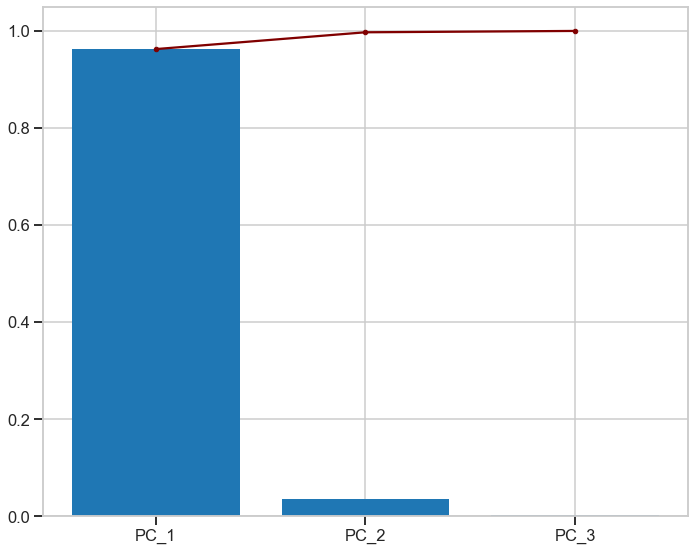

In [513]:
long_term_model.plot_explained_variance()

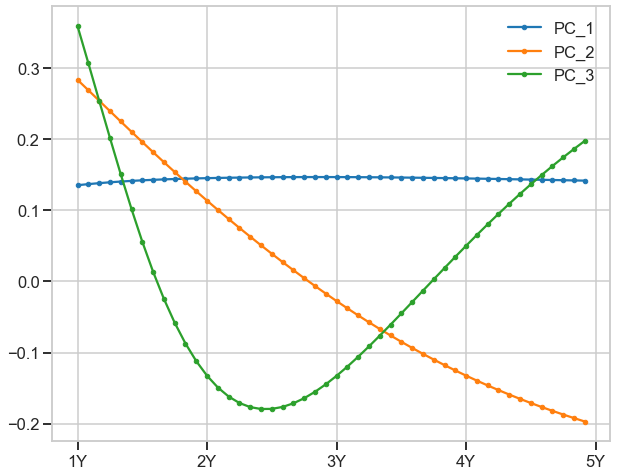

In [514]:
long_term_model.plot_loadings()

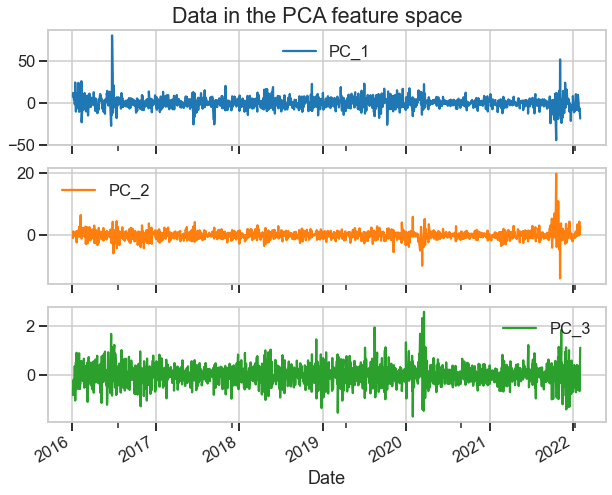

In [515]:
model_long_terms.plot_components()

# Monte Carlo



<AxesSubplot:>

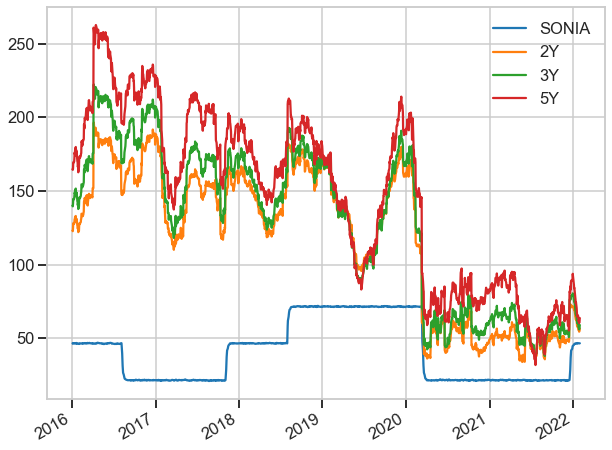

In [611]:
%matplotlib inline
plt.style.use('seaborn-whitegrid')
sns.set_context('talk')
sns.set_palette(sns.color_palette('tab10'))
plt.rcParams['figure.figsize'] = (10, 8)


sonia_sim = sonia_model.simulate(dates=diffs_pca.index,
                                 x0=sonia.iloc[[0], :])

long_term_sim = long_term_model.simulate(dates=diffs_pca.index,
                                         x0=rates[long_tenors].iloc[[0], :])#,
                                         #sonia_scenario = sonia_sim)

simulation = pd.concat([sonia_sim, long_term_sim], axis=1)
simulation[['SONIA', '2Y', '3Y', '5Y']].plot()

,SONIA
2016-01-04,46.480000
2016-01-05,46.555535
2016-01-06,46.572611
2016-01-07,46.301119
2016-01-08,46.168311
...,...
2022-01-25,46.178295
2022-01-26,46.194704
2022-01-27,46.354106
2022-01-28,46.471652


In [451]:
ois_sim

,1Y1M,1Y2M,1Y3M,1Y4M,1Y5M,1Y6M,1Y7M,1Y8M,1Y9M,1Y10M,...,4Y3M,4Y4M,4Y5M,4Y6M,4Y7M,4Y8M,4Y9M,4Y10M,4Y11M,5Y
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-05,0.371407,0.395180,0.420316,0.445831,0.470515,0.492995,0.511803,0.525644,0.533621,0.535160,...,-1.224308,-1.294140,-1.362407,-1.429060,-1.494066,-1.557403,-1.619061,-1.679037,-1.737341,-1.793989
2016-01-06,0.866217,0.841627,0.812282,0.778962,0.742394,0.703274,0.662262,0.619940,0.576772,0.533127,...,-0.473352,-0.497090,-0.520214,-0.542740,-0.564680,-0.586050,-0.606862,-0.627132,-0.646873,-0.666097
2016-01-07,-1.415861,-1.450911,-1.481064,-1.506924,-1.529138,-1.548386,-1.565361,-1.580682,-1.594835,-1.608191,...,-1.966670,-1.976112,-1.985199,-1.993933,-2.002314,-2.010348,-2.018040,-2.025395,-2.032421,-2.039126
2016-01-08,-0.896310,-1.079025,-1.266539,-1.456791,-1.647734,-1.837331,-2.023573,-2.204726,-2.379515,-2.547049,...,-4.613076,-4.633624,-4.653090,-4.671573,-4.689159,-4.705923,-4.721933,-4.737247,-4.751919,-4.765991
2016-01-11,1.369628,1.472944,1.573954,1.672537,1.768684,1.862467,1.954014,2.043461,2.130918,2.216471,...,3.986341,4.024930,4.062230,4.098271,4.133082,4.166695,4.199140,4.230449,4.260655,4.289791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-01-25,-2.191157,-2.131412,-2.058681,-1.975532,-1.884581,-1.788482,-1.689883,-1.591113,-1.493945,-1.399687,...,-0.414990,-0.410760,-0.406787,-0.403009,-0.399373,-0.395833,-0.392352,-0.388901,-0.385455,-0.381997
2022-01-26,0.574741,0.600277,0.622355,0.641898,0.660044,0.678094,0.697442,0.719326,0.744632,0.773952,...,2.765995,2.833699,2.899687,2.963932,3.026419,3.087142,3.146104,3.203316,3.258797,3.312574
2022-01-27,1.128244,1.268939,1.412898,1.558075,1.702232,1.842999,1.977934,2.104915,2.222433,2.329491,...,2.072915,2.023930,1.975625,1.928102,1.881446,1.835724,1.790990,1.747281,1.704623,1.663031


,1Y1M,1Y2M,1Y3M,1Y4M,1Y5M,1Y6M,1Y7M,1Y8M,1Y9M,1Y10M,...,4Y3M,4Y4M,4Y5M,4Y6M,4Y7M,4Y8M,4Y9M,4Y10M,4Y11M,5Y
Date,,,,,,,,,,,,,,,,,,,,,
2016-01-04,57.540194,59.226787,60.956387,62.713531,64.484982,66.259114,68.025572,69.775807,71.503429,73.203783,...,109.770086,110.741022,111.702406,112.654779,113.598627,114.534384,115.462441,116.383145,117.296805,118.203695


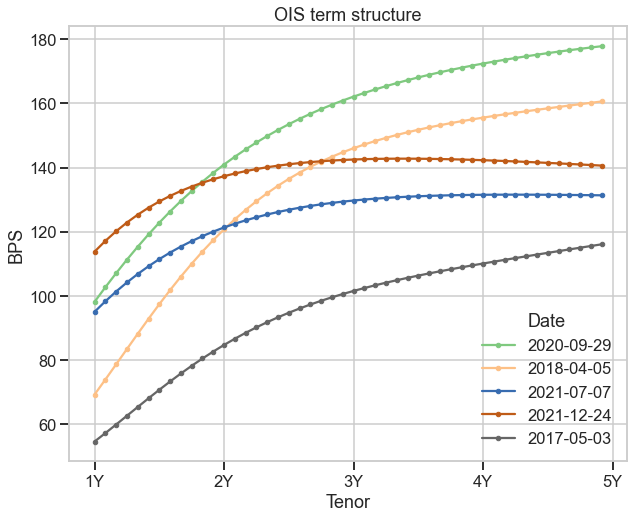

In [376]:
term_structure_df = ois_sim.drop(['SONIA'], axis=1).sample(5).T
term_structure_df.columns = term_structure_df.columns.strftime('%Y-%m-%d')

term_structure_df.plot(marker='.', cmap='Accent')
plt.ylabel('BPS')
plt.xlabel('Tenor')
_ = plt.title('OIS term structure')
tenors = np.array([12, 24, 36, 48, 60]) - 12
plt.xticks(tenors, ois.columns[tenors + 11]);

<IPython.core.display.Javascript object>


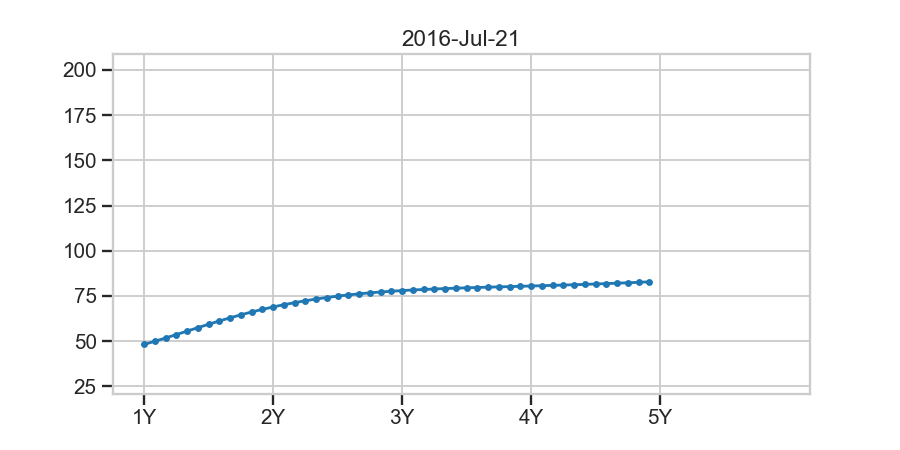

In [378]:
%matplotlib notebook
from matplotlib.animation import FuncAnimation

fig, ax = plt.subplots(figsize=(10, 5))
line, = ax.plot([])     
ax.set_xlim(-2.95, 61.95)
ax.set_ylim(ois_sim.min().min(), ois_sim.max().max())
tenors = np.array([12, 24, 36, 48, 60]) - 12
plt.xticks(tenors, ois.columns[tenors + 11]);

def animate(frame_num):
    y = ois_sim.drop(['SONIA'], axis=1).iloc[[frame_num], :].T
    x = list(range(len(y)))
    line.set_data((x, y))
    line.set_marker('.')
    plt.title(y.columns[0].strftime("%Y-%b-%d"))
    return line

anim = FuncAnimation(fig, animate, frames=len(ois_sim.index), interval=40, repeat=False)
plt.show()